# Preprocesamiento de imágenes

## Carga de etiquetas

In [1]:
import pandas as pd

En primer lugar, cargamos las etiquetas del repositorio, reorganizazmos las columnas y convertimos las categorías.

In [2]:
df_INbreast = pd.read_csv('./Databases/INbreast/INbreast.csv', sep = ';', usecols = ['File Name', 'Bi-Rads', 'Laterality', 'View', 'Acquisition date'])
nuevo_birads = {0: 'incompleto', 1: 'benigno', 2: 'benigno', 3: 'control', 4: 'maligno', 5: 'maligno', 6: 'maligno'}
df_INbreast['Bi-Rads'] = df_INbreast['Bi-Rads'].astype(str).str[0].astype(int).map(nuevo_birads).astype('category')
df_INbreast.head()

,Laterality,View,Acquisition date,File Name,Bi-Rads
0,R,CC,201001,22678622,benigno
1,L,CC,201001,22678646,control
2,R,MLO,201001,22678670,benigno
3,L,MLO,201001,22678694,control
4,R,CC,201001,22614074,maligno


Mostramos por pantalla la distribución de casos por categorías.

<AxesSubplot:>

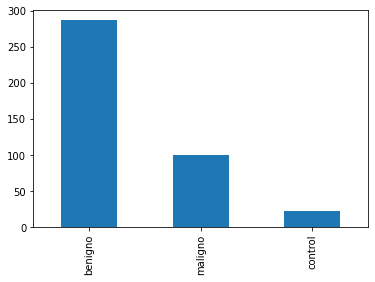

In [3]:
df_INbreast['Bi-Rads'].value_counts().plot(kind = 'bar')

## Carga de rutas de ficheros

In [4]:
import numpy as np
import glob2
import os

Listamos todos los ficheros de mamografías y los incorporamos en el dataframe. Aprovechamos la información del fichero para identificar los diferentes casos (según paciente y lateralidad).

In [5]:
ruta_img = './Databases/INbreast/AllDICOMs/'
filepaths = pd.DataFrame([os.path.basename(x) for x in glob2.glob(ruta_img + '*.dcm')], columns = ['File Path'])
filepaths['File Name'] = ''
filepaths['Case ID'] = ''
for idx, row in filepaths.iterrows():
    filepaths['File Name'][idx] = int(row['File Path'].split('_')[0])
    filepaths['Case ID'][idx] = row['File Path'].split('_')[1]
df_INbreast = df_INbreast.merge(filepaths, on = 'File Name').drop(columns = ['File Name'])
df_INbreast['Case ID'] = df_INbreast['Case ID'] + '_' + df_INbreast['Acquisition date'].astype(str) + '_' + df_INbreast['Laterality'] + '_' + df_INbreast['Bi-Rads'].astype(str)
df_INbreast = df_INbreast.drop(columns = ['Acquisition date', 'Laterality'])
df_INbreast.head()

,View,Bi-Rads,File Path,Case ID
0,CC,benigno,22678622_61b13c59bcba149e_MG_R_CC_ANON.dcm,61b13c59bcba149e_201001_R_benigno
1,CC,control,22678646_61b13c59bcba149e_MG_L_CC_ANON.dcm,61b13c59bcba149e_201001_L_control
2,MLO,benigno,22678670_61b13c59bcba149e_MG_R_ML_ANON.dcm,61b13c59bcba149e_201001_R_benigno
3,MLO,control,22678694_61b13c59bcba149e_MG_L_ML_ANON.dcm,61b13c59bcba149e_201001_L_control
4,CC,maligno,22614074_6bd24a0a42c19ce1_MG_R_CC_ANON.dcm,6bd24a0a42c19ce1_201001_R_maligno


Descartamos aquellos casos que no dispongan de vista CC y MLO (filtrando la vista FB).

In [6]:
one_hot_view = pd.get_dummies(df_INbreast['View'])
df_INbreast = df_INbreast.drop(columns = ['View']).join(one_hot_view)
df_INbreast = df_INbreast[df_INbreast['FB'] != 1].drop(columns = ['FB'])
anom_id = pd.pivot_table(df_INbreast, index = ['Case ID'], values=['CC','MLO'], aggfunc = np.sum)
anom_id = anom_id[anom_id['CC'] + anom_id['MLO'] != 2]
df_INbreast = df_INbreast[~df_INbreast['Case ID'].isin(anom_id.index)]
df_INbreast.shape

(402, 5)

## Carga de imágenes

In [7]:
import numpy as np
from skimage import io
from skimage import color
from skimage.filters import difference_of_gaussians
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

Definimos las funciones auxiliares necesarias para la carga de imágenes.

In [8]:
def right_orient_mammogram(image):
    left_nonzero = cv2.countNonZero(image[:, 0:int(image.shape[1]/2)])
    right_nonzero = cv2.countNonZero(image[:, int(image.shape[1]/2):])
    
    if(left_nonzero < right_nonzero):
        image = cv2.flip(image, 1)

    return image

def read_image(filename, size):
    image = io.imread(filename)
    image = color.rgb2gray(image)
    image = right_orient_mammogram(image)
    image = cv2.resize(image, (size, size), interpolation = cv2.INTER_CUBIC)
    return image

def visualize(image):
    plt.figure(figsize = (10, 10))
    plt.axis('off')
    plt.imshow(image)
    return

def crop(img):
    """
    Crop ROI from image.
    """

    # Otsu's thresholding after Gaussian filtering
    blur = cv2.GaussianBlur(img, (5, 5), 0).astype('uint8')
    _, breast_mask = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    cnts, _ = cv2.findContours(breast_mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnt = max(cnts, key = cv2.contourArea)
    x, y, w, h = cv2.boundingRect(cnt)

    return img[y:y+h, x:x+w]

def zero_padding(img, size):
    """
    Zero padding to (size x size).
    """

    top = round((size - img.shape[0])/2)
    bottom = size - (img.shape[0] + top)
    left = round((size - img.shape[1])/2)
    right = size - (img.shape[1] + left)

    img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, 0)
    
    return img

def multi_dog(img):
    img = np.dstack((difference_of_gaussians(img, 2), difference_of_gaussians(img, 4), difference_of_gaussians(img, 8)))
    img = cv2.normalize(img, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX).astype(int)
    
    return img

Cargamos las imágenes asociadas al dataset generado en el apartado anterior.

In [9]:
size_img = 512
imgs_loaded = pd.DataFrame(columns =  ['File Path', 'Image Array'])

for img_path in df_INbreast['File Path']:
    img_array = read_image(ruta_img + img_path, size_img).astype(float)
    img_array *= 255.0 / img_array.max()
    img_array = multi_dog(zero_padding(crop(img_array), size_img))
    imgs_loaded = imgs_loaded.append(pd.DataFrame([[img_path, img_array]], columns = ['File Path', 'Image Array']), ignore_index = True)
    
df_INbreast = df_INbreast.merge(imgs_loaded, on = 'File Path', how = 'left').drop(columns = ['File Path'])
df_INbreast.head()

<ipython-input-8-70a96b84e66e>:12: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  image = color.rgb2gray(image)


,Bi-Rads,Case ID,CC,MLO,Image Array
0,benigno,61b13c59bcba149e_201001_R_benigno,1,0,"[[[87, 87, 87], [87, 87, 87], [87, 87, 87], [8..."
1,control,61b13c59bcba149e_201001_L_control,1,0,"[[[99, 99, 99], [99, 99, 99], [99, 99, 99], [9..."
2,benigno,61b13c59bcba149e_201001_R_benigno,0,1,"[[[99, 99, 99], [99, 99, 99], [99, 99, 99], [9..."
3,control,61b13c59bcba149e_201001_L_control,0,1,"[[[103, 103, 103], [103, 103, 103], [103, 103,..."
4,maligno,6bd24a0a42c19ce1_201001_R_maligno,1,0,"[[[96, 96, 96], [96, 96, 96], [96, 96, 96], [9..."


Reorganizamos el dataframe para juntar las dos vistas en la misma fila.

In [10]:
images_cc = df_INbreast[df_INbreast['CC'] == 1].drop(columns = ['Bi-Rads', 'CC', 'MLO']).rename(columns = {'Image Array': 'CC Image'})
images_mlo = df_INbreast[df_INbreast['MLO'] == 1].drop(columns = ['Bi-Rads', 'CC', 'MLO']).rename(columns = {'Image Array': 'MLO Image'})
df_INbreast = df_INbreast[['Bi-Rads', 'Case ID']].drop_duplicates()
df_INbreast = df_INbreast.merge(images_cc, on = 'Case ID')
df_INbreast = df_INbreast.merge(images_mlo, on = 'Case ID')
df_INbreast.shape

(201, 4)

In [11]:
df_INbreast.head()

,Bi-Rads,Case ID,CC Image,MLO Image
0,benigno,61b13c59bcba149e_201001_R_benigno,"[[[87, 87, 87], [87, 87, 87], [87, 87, 87], [8...","[[[99, 99, 99], [99, 99, 99], [99, 99, 99], [9..."
1,control,61b13c59bcba149e_201001_L_control,"[[[99, 99, 99], [99, 99, 99], [99, 99, 99], [9...","[[[103, 103, 103], [103, 103, 103], [103, 103,..."
2,maligno,6bd24a0a42c19ce1_201001_R_maligno,"[[[96, 96, 96], [96, 96, 96], [96, 96, 96], [9...","[[[100, 100, 100], [100, 100, 100], [100, 100,..."
3,benigno,6bd24a0a42c19ce1_201001_L_benigno,"[[[102, 102, 102], [102, 102, 102], [102, 102,...","[[[93, 93, 93], [93, 93, 93], [93, 93, 93], [9..."
4,benigno,97ec8cadfca70d32_201001_L_benigno,"[[[111, 111, 111], [111, 111, 111], [111, 111,...","[[[94, 94, 94], [94, 94, 94], [94, 94, 94], [9..."


<AxesSubplot:>

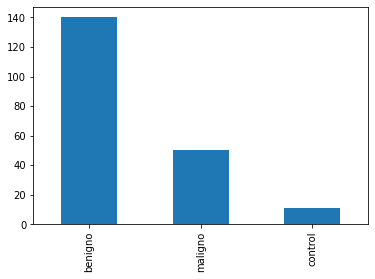

In [12]:
df_INbreast['Bi-Rads'].value_counts().plot(kind = 'bar')

## Balanceo del dataset - SMOTE

In [13]:
from imblearn.over_sampling import SMOTE

Convertimos los arrays de imágenes de la vista MLO del dataframe en un único array para poder tratarlo. Extraemos también las categorías de cada caso.

In [14]:
X_train = np.array(df_INbreast['MLO Image'].tolist())
X_train = X_train.reshape(X_train.shape[0], 3 * size_img ** 2)
y_train, codes = pd.factorize(df_INbreast['Bi-Rads'])

Generamos tantos arrays de imágenes nuevas como para equilibrar las categorías del dataset.

In [15]:
unique, counts = np.unique(y_train, return_counts = True)
strategy = {0:counts.max(), 1:counts.max(), 2:counts.max()}
smote = SMOTE(sampling_strategy = strategy)
X_smote, y_smote = smote.fit_resample(X_train, y_train)
X_smote = X_smote.reshape(X_smote.shape[0], size_img, size_img, 3)

Como se puede observar en una de las imágenes generadas artificialmente, la aplicación de SMOTE no da buenos resultados. Esta generación artificial debería abordarse con un Encoder o con una GAN, y replicarse también a la vista CC.

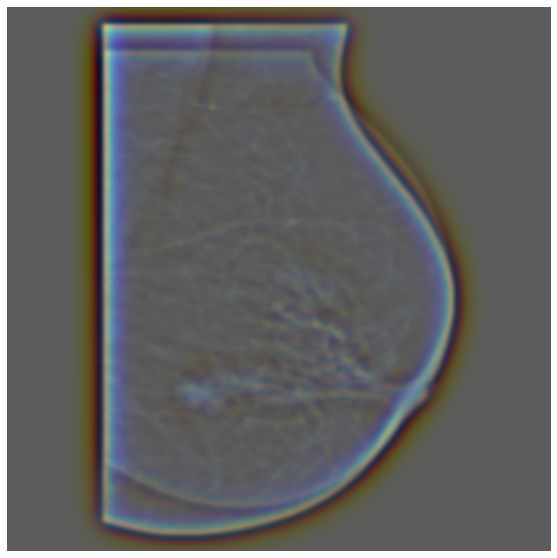

In [16]:
visualize(X_smote[-6])

## Balanceo del dataset - Data augmentation sobre clases infrarrepresentadas

In [17]:
import albumentations as A

Definición de funciones auxiliares.

In [18]:
def vertFlip(img):
    transform = A.VerticalFlip(p = 1)
    return transform(image = img)['image']

Generamos la versión volteada verticalmente para aquellas imágenes que no correspondan a un caso benigno para pode equilibrar un poco el dataset.

<AxesSubplot:>

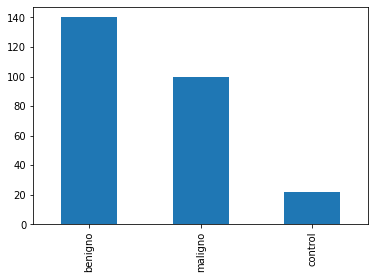

In [19]:
for index, row in df_INbreast.iterrows():
    if row['Bi-Rads'] != 'benigno':
        new_row = pd.DataFrame([[str(row['Bi-Rads']), str(row['Case ID'] + '_Flip'), vertFlip(row['CC Image']), vertFlip(row['MLO Image'])]], 
                               columns = list(df_INbreast.columns))
        df_INbreast = df_INbreast.append(new_row, ignore_index = True)
    
df_INbreast['Bi-Rads'].value_counts().plot(kind = 'bar')

## Almacén de datos en fichero externo

Establecemos el Case ID como el índice del dataframe y lo almacenamos en un fichero externo para su uso en otros notebooks.

In [20]:
df_INbreast = df_INbreast.set_index('Case ID', drop = True)
df_INbreast.head()

,Bi-Rads,CC Image,MLO Image
Case ID,,,
61b13c59bcba149e_201001_R_benigno,benigno,"[[[87, 87, 87], [87, 87, 87], [87, 87, 87], [8...","[[[99, 99, 99], [99, 99, 99], [99, 99, 99], [9..."
61b13c59bcba149e_201001_L_control,control,"[[[99, 99, 99], [99, 99, 99], [99, 99, 99], [9...","[[[103, 103, 103], [103, 103, 103], [103, 103,..."
6bd24a0a42c19ce1_201001_R_maligno,maligno,"[[[96, 96, 96], [96, 96, 96], [96, 96, 96], [9...","[[[100, 100, 100], [100, 100, 100], [100, 100,..."
6bd24a0a42c19ce1_201001_L_benigno,benigno,"[[[102, 102, 102], [102, 102, 102], [102, 102,...","[[[93, 93, 93], [93, 93, 93], [93, 93, 93], [9..."
97ec8cadfca70d32_201001_L_benigno,benigno,"[[[111, 111, 111], [111, 111, 111], [111, 111,...","[[[94, 94, 94], [94, 94, 94], [94, 94, 94], [9..."


In [21]:
df_INbreast.to_pickle('./df_INbreast.pkl')

## Visualización del resultado final del preprocesado

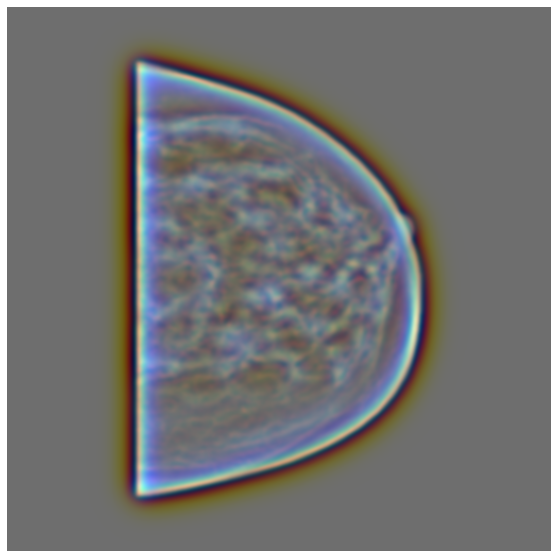

In [22]:
visualize(df_INbreast['CC Image'][22])

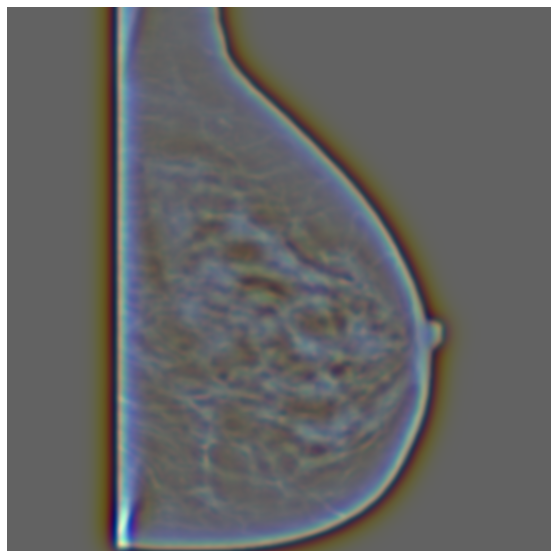

In [23]:
visualize(df_INbreast['MLO Image'][22])